## Decision tree classification

### Imports and global variables

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [250]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']

df_all = pd.concat([df,df_test], axis=0).reset_index()
del df_all['index']

print df.shape
print df_test.shape
print df_all.shape
df_all.head(2)

(78, 64)
(14, 64)
(92, 64)


,adj,adj_compare,adj_sup,adv,adv_compare,adv_part,adv_sup,avg_sent_len,avg_word_len,best_seller,...,verb_count,verb_ger,verb_past,verb_pp,verb_sing_pres,wh_adv,wh_determ,wh_poss,wh_pronoun,word_count
0,0.069588,0.003314,0.002129,0.063591,0.001534,0.006965,0.000265,14,4,1,...,29612.0,0.023553,0.070598,0.023559,0.019427,0.005545,0.004228,0.000024,0.004685,166265
1,0.065146,0.004336,0.003233,0.067069,0.002154,0.005526,0.000405,11,4,1,...,36339.0,0.019928,0.078151,0.024544,0.015360,0.004794,0.003826,0.000043,0.004250,207548


In [251]:
# subset the data
sf = df_all[df_all['sci_fi']==1]
rm = df_all[df_all['sci_fi']==0]
print sf.shape
print rm.shape

(47, 64)
(45, 64)


#### Science-fiction

In [258]:
y_sf = sf['best_seller']
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

print y_sf.shape, X_sf.shape

X_sf, X_sf_test, y_sf, y_sf_test = train_test_split(X_sf, y_sf, test_size=0.3)

print X_sf.shape, y_sf.shape
print X_sf_test.shape, y_sf_test.shape

(47,) (47, 54)
(32, 54) (32,)
(15, 54) (15,)


In [174]:
dtc = DecisionTreeClassifier(max_depth=3)
dtc_sf_model = dtc.fit(X_sf, y_sf)
dtc_sf_proba = dtc_sf_model.predict_log_proba(X_sf_test)
y_sf_pp = dtc_sf_model.predict_log_proba(X_sf_test)[:,1]
dtc_scores = cross_val_score(dtc, X_sf, y_sf, cv=10)

print dtc_scores, np.mean(dtc_scores)

[ 1.          0.75        1.          0.5         0.5         0.25        0.5
  0.25        0.75        0.66666667] 0.616666666667


In [227]:
dctc = DecisionTreeClassifier()

dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10]
}
  
dtc_gs = GridSearchCV(dctc, dtc_params, n_jobs=-1, cv=5, verbose=1)
sf_model = dtc_gs.fit(X_sf, y_sf)
proba_sf = sf_model.predict_log_proba(X_sf_test)
dtc_best_estimator = dtc_gs.best_estimator_

print "Best estimator", dtc_best_estimator

print 
dct_best_param = dtc_gs.best_params_
print "Best parameters",  dct_best_param 

print 
print "Best score", dtc_gs.best_score_

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    1.8s


Best estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Best parameters {'max_features': 'sqrt', 'min_samples_split': 5, 'max_depth': 3}

Best score 0.769230769231


[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    2.4s finished


In [228]:
# predict from test data
y_sf_pred= dtc_gs.predict(X_sf_test)
print y_sf_pred.shape, y_sf_test.shape

(8,) (8,)


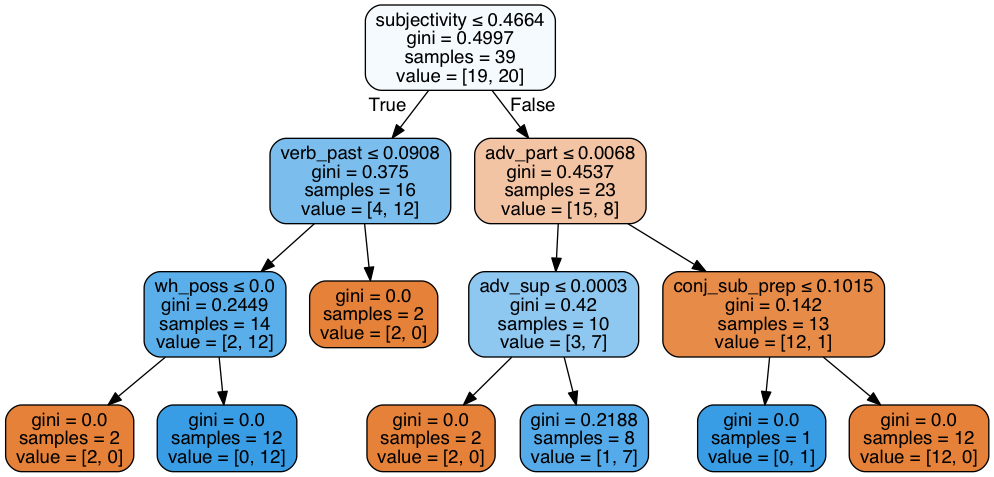

In [235]:
dot_data = StringIO()

# use best parameters found above
dctc_best= DecisionTreeClassifier(max_features='sqrt', min_samples_split=5, max_depth=3)
dctc_best.fit(X_sf, y_sf)

# graph
export_graphviz(dctc_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_sf.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [236]:
# print feature importances
feature_importance = pd.DataFrame({ 'feature':X_sf.columns, 
                                   'importance':dctc_best.feature_importances_
})

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(8)

,feature,importance
26,adv_part,0.247425
37,wh_poss,0.193299
4,subjectivity,0.172090
30,verb_past,0.144974
25,adv_sup,0.138128
10,conj_sub_prep,0.104084
40,verb.change,0.000000
31,verb_ger,0.000000


In [237]:
class_rpt = classification_report(y_sf_test, y_sf_pred)
print class_rpt 

             precision    recall  f1-score   support

          0       0.33      0.25      0.29         4
          1       0.40      0.50      0.44         4

avg / total       0.37      0.38      0.37         8



Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    2.6s finished


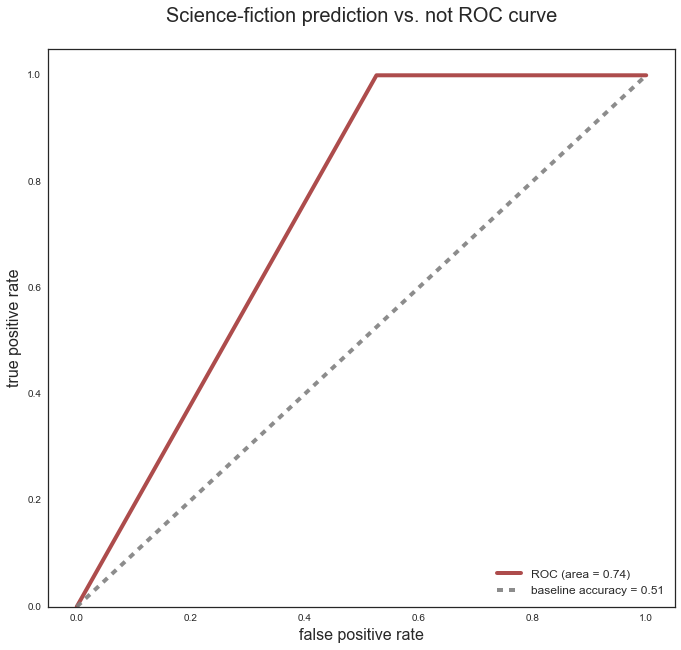

In [94]:
plot_roc(sf_model, X_sf, y_sf, 'Science-fiction prediction')

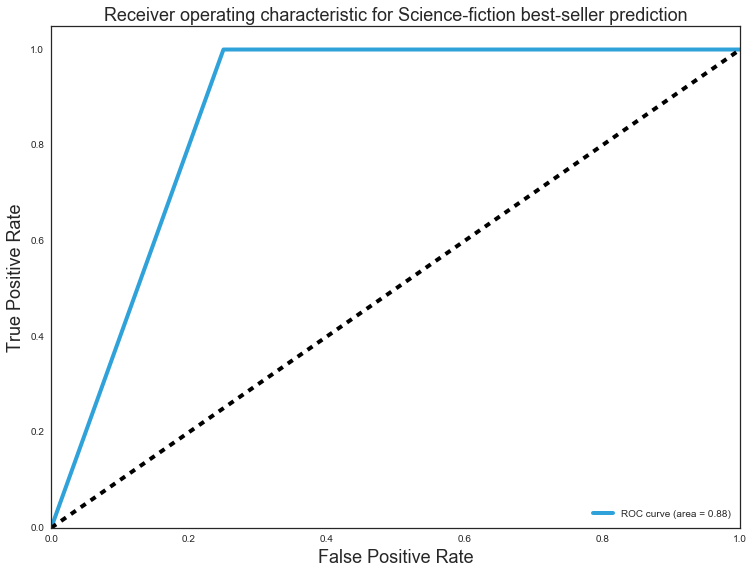

In [162]:
plot_roc_curve(target=y_sf_test, predict_proba=dtc_sf_proba[:,1], title='Science-fiction best-seller prediction')

#### Romance

In [256]:
y_rm = rm['best_seller']
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

print y_rm.shape, X_rm.shape

X_rm, X_rm_test, y_rm, y_rm_test = train_test_split(X_rm, y_rm, test_size=0.3)

print X_rm.shape, y_rm.shape
print X_rm_test.shape, y_rm_test.shape

(45,) (45, 54)


In [187]:
dtc_rm = DecisionTreeClassifier(max_depth=4)
dtc_rm_model = dtc_rm.fit(X_rm, y_rm)
dtc_proba_rm = dtc_rm_model.predict_log_proba(X_rm_test)
y_rm_pp = dtc_rm_model.predict_log_proba(X_rm_test)[:,1]
dtc_rm_scores = cross_val_score(dtc_rm, X_rm, y_rm, cv=10)

print dtc_rm_scores, np.mean(dtc_rm_scores)

[ 0.75        0.75        0.75        0.5         0.75        0.5         0.75
  0.5         0.75        0.33333333] 0.633333333333


In [242]:
dctc_rm = DecisionTreeClassifier()

dtc_rm_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10]
}
   
dtc_rm_gs = GridSearchCV(dctc_rm, dtc_rm_params, n_jobs=-1, cv=5, verbose=1)
rm_model = dtc_rm_gs.fit(X_rm, y_rm)
proba_rm = rm_model.predict_log_proba(X_rm_test)
y_rm_pp = rm_model.predict_log_proba(X_rm_test)[:,1]
dtc_rm_best_estimator = dtc_rm_gs.best_estimator_

print "Best estimator", dtc_rm_best_estimator

print 
dct_rm_best_param = dtc_rm_gs.best_params_
print "Best parameters",  dct_rm_best_param 

print 
print "Best score", dtc_rm_gs.best_score_

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:    1.7s


Best estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=5, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Best parameters {'max_features': 5, 'min_samples_split': 2, 'max_depth': None}

Best score 0.74358974359


[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    2.4s finished


In [243]:
# predict from test data
#probabilities = model.predict_log_proba(X)

y_rm_pred= dtc_rm_gs.predict(X_rm_test)
y_rm_pp = dtc_rm_gs.predict_log_proba(X_rm_test)[:,1]
print y_rm_pred.shape, y_rm_test.shape

(6,) (6,)


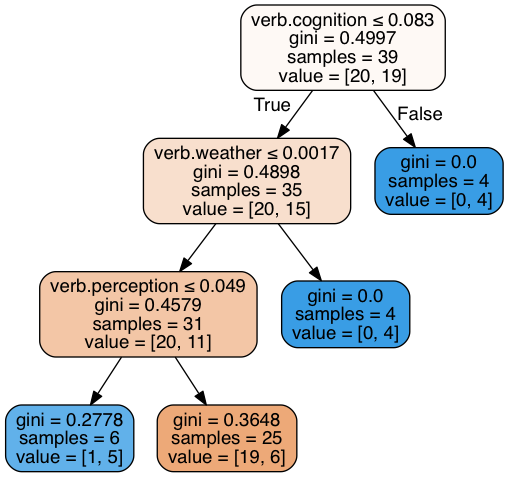

In [246]:
dot_data = StringIO()

# use best parameters found above
dctc_rm_best= DecisionTreeClassifier(max_features=5, min_samples_split=4, max_depth=3)
z = dctc_rm_best.fit(X_rm, y_rm)
proba_z = z.predict_log_proba(X_rm_test)

# graph
export_graphviz(dctc_rm_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_rm.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [247]:
# print feature importances
feature_importance_rm = pd.DataFrame({ 'feature':X_rm.columns, 
                                   'importance':dctc_rm_best.feature_importances_
})

feature_importance_rm.sort_values('importance', ascending=False, inplace=True)
feature_importance_rm.head(5)

,feature,importance
49,verb.perception,0.391573
53,verb.weather,0.338981
41,verb.cognition,0.269446
51,verb.social,0.000000
50,verb.possession,0.000000


In [248]:
class_rpt_rm = classification_report(y_rm_test, y_rm_pred)
print class_rpt_rm

             precision    recall  f1-score   support

          0       0.25      0.33      0.29         3
          1       0.00      0.00      0.00         3

avg / total       0.12      0.17      0.14         6



Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    2.4s finished


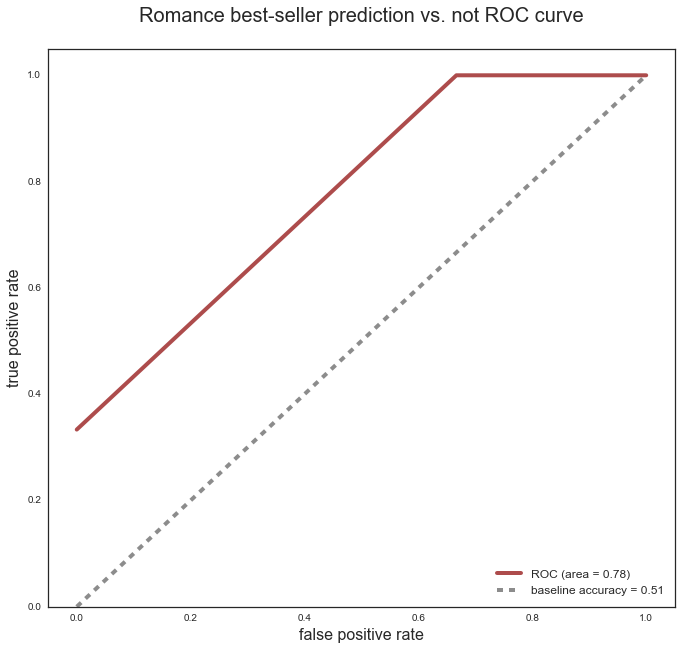

In [224]:
plot_roc(rm_model,X_rm, X_rm_test, y_rm, y_rm_test, 'Romance best-seller prediction')

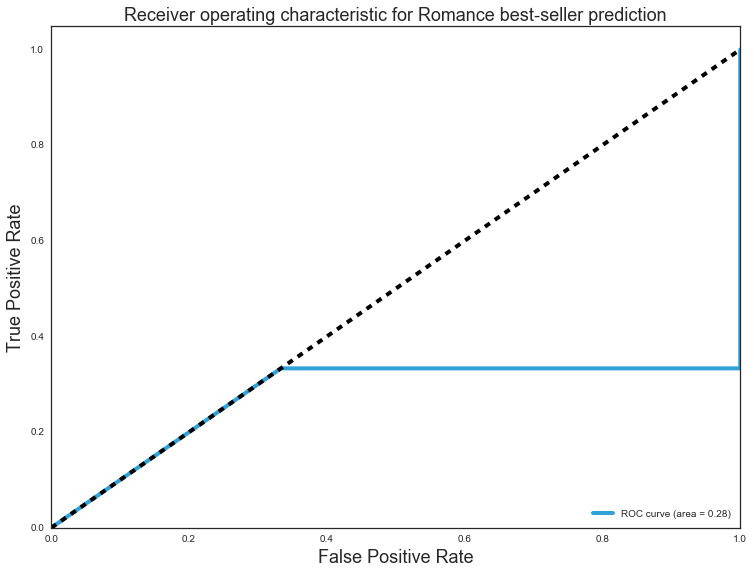

In [219]:
plot_roc_curve(target=y_rm_test, predict_proba=proba_rm[:,1], title='Romance best-seller prediction')

In [211]:
plt.style.use('seaborn-white')    
def plot_roc(mod, X, X_test,y,y_test, varname):
    mod.fit(X, y)
    y_pp = mod.predict_log_proba(X_test)[:, 1]
    fpr_, tpr_, _ = roc_curve(y_test, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(10,10))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)
    
    axr.legend(loc="lower right", fontsize=12)
    plt.show()

In [89]:
def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

In [167]:

def plot_roc2(y_test,y_pp):
    fpr_, tpr_, _ = roc_curve(y_test, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y_test)) + 0.5

    fig, axr = plt.subplots(figsize=(16,10))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4)#, label='baseline accuracy = %0.2f' % acc_)
    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('False Positive Rate', fontsize=16)
    axr.set_ylabel('True Positive Rate', fontsize=16)
    axr.set_title('ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    #path = './assets/roc_cu
    plt.show()